In [1]:
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
import matplotlib

from sklearn.metrics import roc_curve, auc
import scipy.stats as stats

# aesthetics for plots:
font = {'family': 'arial',
        'size': 12}
matplotlib.rc('font', **font)

%matplotlib inline

# Ovarian and control plasma sample analysis via MDBC

### Inclusion of all reads, normalized by plasma input into DREAMing.

### Read Counts
##### cutoffs = detected reads >= MD, per mL plasma

### Folders:
##### ./training_input2bg_FracNorm/
##### ./validation_input2bg_FracNorm/

### inputs for MDBC:
##### ./READtoMD.DT.20190211-DREAMing_well_melt_temps_raw.input2bg.csv
##### ./fractions-2.csv

In [2]:
training_sum_path = "training_input2bg_FracNorm-2/MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.READ-COUNT-SUMMARY.csv"

trainingSumDF = pd.read_csv(training_sum_path)
trainingSumDF = trainingSumDF[trainingSumDF['MD Cutoffs'] >= 0.0]

print('Training Set Summary Table:')
print(trainingSumDF[['MD Cutoffs',
                     'optimal read count cutoff', 'AUC', 'TPR', '1 - FPR']])

optimalMD = 0.60 # from MDBC output for read counts

# cutoffs to use on validation set:
md0_cutoff = trainingSumDF[trainingSumDF['MD Cutoffs']
                           == 0.0]['optimal read count cutoff'].values[0]
mdOpt_cutoff = trainingSumDF[trainingSumDF['MD Cutoffs']
                            == optimalMD]['optimal read count cutoff'].values[0]
msp_cutoff = trainingSumDF[trainingSumDF['MD Cutoffs']
                            == 0.95]['optimal read count cutoff'].values[0]


md0_train_path = "training_input2bg_FracNorm-2/MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.0.0_MD-COUNTS_VALS.csv"
msp_train_path = "training_input2bg_FracNorm-2/MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.0.95_MD-COUNTS_VALS.csv"
mdOpt_train_path = "training_input2bg_FracNorm-2/MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.0.6_MD-COUNTS_VALS.csv"

md0_val_path = "validation_input2bg_FracNorm-2/MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.0.0_MD-COUNTS_VALS.csv"
msp_val_path = "validation_input2bg_FracNorm-2/MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.0.95_MD-COUNTS_VALS.csv"
mdOpt_val_path = "validation_input2bg_FracNorm-2/MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.0.6_MD-COUNTS_VALS.csv"

Training Set Summary Table:
    MD Cutoffs  optimal read count cutoff       AUC       TPR   1 - FPR
0         0.00                  14.084507  0.489744  0.807692  0.311111
1         0.05                  14.084507  0.489744  0.807692  0.311111
2         0.10                   7.936508  0.553846  0.923077  0.355556
3         0.15                   7.216495  0.633761  0.846154  0.466667
4         0.20                   7.216495  0.633761  0.846154  0.466667
5         0.25                   6.185567  0.641453  0.846154  0.466667
6         0.30                   6.172840  0.653846  0.846154  0.488889
7         0.35                   6.172840  0.653846  0.846154  0.488889
8         0.40                   4.938272  0.691026  0.807692  0.600000
9         0.45                   6.756757  0.691026  0.730769  0.711111
10        0.50                   6.741573  0.697436  0.692308  0.777778
11        0.55                   6.741573  0.697436  0.692308  0.777778
12        0.60                   6.7

### Line graph, training set

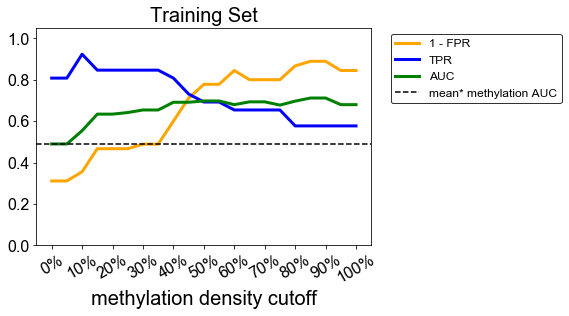

In [3]:
fig, ax = plt.subplots()

x = trainingSumDF['MD Cutoffs'].values
y1 = trainingSumDF['1 - FPR'].values
plt.plot(x, y1, lw=3, color='orange', label='1 - FPR')

y3 = trainingSumDF['TPR'].values
plt.plot(x, y3, lw=3, color='b', label='TPR')

y2 = trainingSumDF['AUC'].values
plt.plot(x, y2, lw=3, color='green', label='AUC')

aveMethAUC = trainingSumDF[trainingSumDF['MD Cutoffs']
                           == 0.0]['AUC'].values[0]
ax.axhline(y=aveMethAUC, linestyle='--', color='k',
           label='mean* methylation AUC')
#ax.axvline(x=optimalMD, linestyle='--', color='r',
#           label='MDBC optimal MD cutoff')

plt.ylim([0, 1.05])
xtick_pos = np.arange(0, len(x), 1)
ytick_pos = np.arange(0, 1.1, .2)
plt.xticks(np.arange(0, 1.1, 0.1), [
           str(int(f*100))+'%' for f in np.arange(0, 1.1, 0.1)], rotation=30, fontsize=16)
plt.yticks(ytick_pos, [str(round(i, 2)) for i in ytick_pos], fontsize=16)

plt.title('Training Set', fontsize=20)
plt.xlabel('methylation density cutoff', fontsize=20)
#plt.ylabel('1-FPR\nAUC\nTPR', rotation=0, fontsize=20, labelpad=40)
ax.yaxis.set_label_coords(-0.20, 0.40)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left",
           fontsize=12, edgecolor='k')
#plt.show()
plt.savefig('Figure3B_trainingSet_lineplot.png',
            bbox_inches='tight', pad_inches=0.5, dpi=500)

In [4]:
# For Training Set ROC curves

# -----------------------------------------------------------
md0_df = pd.read_csv(md0_train_path)
md0_cases = md0_df['cases'].dropna().values.tolist()
md0_controls = md0_df['controls'].dropna().values.tolist()

md0_labels = [1 for i in md0_cases]
for i in md0_controls:
    md0_labels.append(0)
md0_values = md0_cases + md0_controls

md0_fpr, md0_tpr, md0_thresholds = roc_curve(md0_labels, md0_values)
md0_roc_auc = auc(md0_fpr, md0_tpr)
md0_optimal_idx = np.argmax(md0_tpr - md0_fpr)
md0_optimal_threshold = md0_thresholds[md0_optimal_idx]
print(md0_roc_auc)

# -----------------------------------------------------------
msp_df = pd.read_csv(msp_train_path)
msp_cases = msp_df['cases'].dropna().values.tolist()
msp_controls = msp_df['controls'].dropna().values.tolist()

msp_labels = [1 for i in msp_cases]
for i in msp_controls:
    msp_labels.append(0)
msp_values = msp_cases + msp_controls

msp_fpr, msp_tpr, msp_thresholds = roc_curve(msp_labels, msp_values)
msp_roc_auc = auc(msp_fpr, msp_tpr)
msp_optimal_idx = np.argmax(msp_tpr - msp_fpr)
msp_optimal_threshold = msp_thresholds[msp_optimal_idx]

# -----------------------------------------------------------
mdOpt_df = pd.read_csv(mdOpt_train_path)
mdOpt_cases = mdOpt_df['cases'].dropna().values.tolist()
mdOpt_controls = mdOpt_df['controls'].dropna().values.tolist()

mdOpt_labels = [1 for i in mdOpt_cases]
for i in mdOpt_controls:
    mdOpt_labels.append(0)
mdOpt_values = mdOpt_cases + mdOpt_controls

mdOpt_fpr, mdOpt_tpr, mdOpt_thresholds = roc_curve(mdOpt_labels, mdOpt_values)
mdOpt_roc_auc = auc(mdOpt_fpr, mdOpt_tpr)
mdOpt_optimal_idx = np.argmax(mdOpt_tpr - mdOpt_fpr)
mdOpt_optimal_threshold = mdOpt_thresholds[mdOpt_optimal_idx]

0.4897435897435898


##### R library(pROC)

optimal MD cutoff:
> mdopt = read.csv("MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.0.6_MD-COUNTS_VALS.csv")
> mdopt_controlVals = mdopt$controls[!is.na(mdopt$controls)]
> mdopt_caseVals = mdopt$cases[!is.na(mdopt$cases)]
> mdopt_values = c(mdopt_caseVals, mdopt_controlVals)
> mdopt_controlLabel = rep(0, length(mdopt_controlVals))
> mdopt_caseLabel = rep(1, length(mdopt_caseVals))
> mdopt_labels = c(mdopt_caseLabel, mdopt_controlLabel)
> mdopt_rocVals = roc(mdopt_labels, mdopt_values)
Setting levels: control = 0, case = 1
Setting direction: controls < cases
> ci.auc(mdopt_rocVals, method="bootstrap")
  |============================================================| 100%
95% CI: 0.5358-0.8132 (2000 stratified bootstrap replicates)

mean* methylation
> md0 = read.csv("MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.0.0_MD-COUNTS_VALS.csv")
> md0_controlVals = md0$controls[!is.na(md0$controls)]
> md0_caseVals = md0$cases[!is.na(md0$cases)]
> md0_values = c(md0_caseVals, md0_controlVals)
> md0_controlLabel = rep(0, length(md0_controlVals))
> md0_caseLabel = rep(1, length(md0_caseVals))
> md0_labels = c(md0_caseLabel, md0_controlLabel)
> md0_rocVals = roc(md0_labels, md0_values)
Setting levels: control = 0, case = 1
  |=========================================================================| 100%
95% CI: 0.3538-0.6256 (2000 stratified bootstrap replicates)

msp*
> msp = read.csv("MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.0.95_MD-COUNTS_VALS.csv")
> msp_controlVals = msp$controls[!is.na(msp$controls)]
> msp_caseVals = msp$cases[!is.na(msp$cases)]
> msp_values = c(msp_caseVals, msp_controlVals)
> msp_controlLabel = rep(0, length(msp_controlVals))
> msp_caseLabel = rep(1, length(msp_caseVals))
> msp_labels = c(msp_caseLabel, msp_controlLabel)
> msp_rocVals = roc(msp_labels, msp_values)
Setting levels: control = 0, case = 1
Setting direction: controls < cases
> ci.auc(msp_rocVals, method="bootstrap")
  |============================================================| 100%
95% CI: 0.5461-0.8064 (2000 stratified bootstrap replicates)

### ROC curve, training set

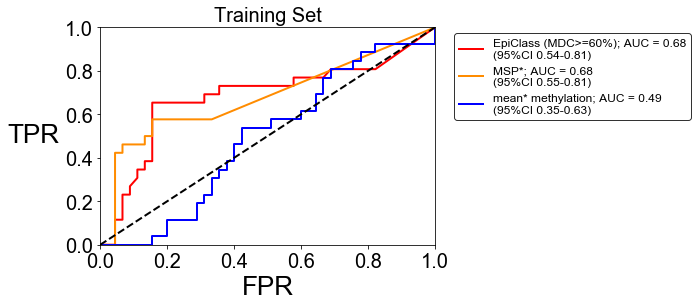

In [5]:
fig, ax = plt.subplots()
lw = 2

plt.plot(mdOpt_fpr, mdOpt_tpr, color='red',
         lw=lw, label='EpiClass (MDC>=60%)' + '; AUC = %0.2f' % mdOpt_roc_auc + '\n(95' + '%' + 'CI 0.54-0.81)')

plt.plot(msp_fpr, msp_tpr, color='darkorange',
         lw=lw, label='MSP*' + '; AUC = %0.2f' % msp_roc_auc + '\n(95' + '%' + 'CI 0.55-0.81)')

plt.plot(md0_fpr, md0_tpr, color='blue',
         lw=lw, label='mean* methylation' + '; AUC = %0.2f' % md0_roc_auc + '\n(95' + '%' + 'CI 0.35-0.63)')

plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')

plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.00])

plt.title('Training Set', fontsize=20)
plt.xlabel('FPR', fontsize=26)
plt.ylabel('TPR', rotation=0, fontsize=26)
ax.yaxis.set_label_coords(-0.20, 0.45)

plt.xticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                   for i in np.arange(0, 1.1, .2)], fontsize=20)
plt.yticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                   for i in np.arange(0, 1.1, .2)], fontsize=20)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=12, edgecolor='k')
#plt.show()
plt.savefig('Figure3C_trainingSet_MDcutoffs_ROC.png',
            bbox_inches='tight', pad_inches=0.5, dpi=500)

# Validation set (below)

In [6]:
validation_sum_path = "validation_input2bg_FracNorm-2/MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.READ-COUNT-SUMMARY.csv"

validationSumDF = pd.read_csv(validation_sum_path)
validationSumDF = validationSumDF[validationSumDF['MD Cutoffs'] >= 0.0]
validationSumDF[['MD Cutoffs', 'optimal read count cutoff', 'AUC', 'TPR', '1 - FPR']]

,MD Cutoffs,optimal read count cutoff,AUC,TPR,1 - FPR
0,0.00,21.186441,0.696181,0.833333,0.666667
1,0.05,21.186441,0.696181,0.833333,0.666667
2,0.10,10.000000,0.729167,0.916667,0.666667
3,0.15,9.333333,0.864583,0.916667,0.750000
4,0.20,9.333333,0.864583,0.916667,0.750000
5,0.25,2.083333,0.920139,1.000000,0.666667
6,0.30,9.333333,0.946181,0.833333,0.916667
7,0.35,9.333333,0.946181,0.833333,0.916667
8,0.40,5.000000,0.940972,0.916667,1.000000
9,0.45,5.000000,0.940972,0.916667,1.000000


### Line graph, validation set

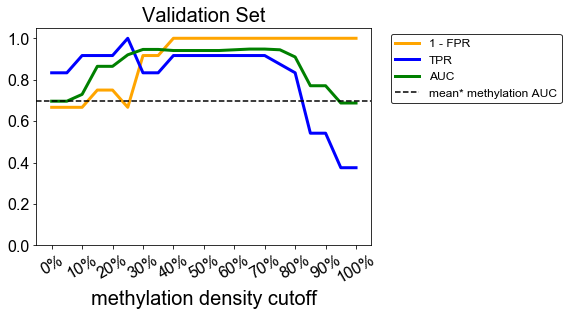

In [7]:
fig, ax = plt.subplots()

x = validationSumDF['MD Cutoffs'].values
y1 = validationSumDF['1 - FPR'].values
plt.plot(x, y1, lw=3, color='orange', label='1 - FPR')

y3 = validationSumDF['TPR'].values
plt.plot(x, y3, lw=3, color='b', label='TPR')

y2 = validationSumDF['AUC'].values
plt.plot(x, y2, lw=3, color='green', label='AUC')

aveMethAUC = validationSumDF[validationSumDF['MD Cutoffs']
                             == 0.0]['AUC'].values[0]
ax.axhline(y=aveMethAUC, linestyle='--', color='k',
           label='mean* methylation AUC')
#ax.axvline(x=optimalMD, linestyle='--', color='r', label='MDBC optimal MD cutoff')

plt.ylim([0, 1.05])
xtick_pos = np.arange(0, len(x), 1)
ytick_pos = np.arange(0, 1.1, .2)
plt.xticks(np.arange(0, 1.1, 0.1), [
           str(int(f*100))+'%' for f in np.arange(0, 1.1, 0.1)], rotation=30, fontsize=16)
plt.yticks(ytick_pos, [str(round(i, 2)) for i in ytick_pos], fontsize=16)

plt.title('Validation Set', fontsize=20)
plt.xlabel('methylation density cutoff', fontsize=20)
#plt.ylabel('1-FPR\nAUC\nTPR', rotation=0, fontsize=20, labelpad=40)
ax.yaxis.set_label_coords(-0.20, 0.40)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left",
           fontsize=12, edgecolor='k')
#plt.show()
plt.savefig('FigureS8B_validationSet_lineplot.png',
            bbox_inches='tight', pad_inches=0.5, dpi=500)

In [8]:
# -----------------------------------------------------------
md0_df = pd.read_csv(md0_val_path)
md0_cases = md0_df['cases'].dropna().values.tolist()
md0_controls = md0_df['controls'].dropna().values.tolist()

md0_labels = [1 for i in md0_cases]
for i in md0_controls:
    md0_labels.append(0)
md0_values = md0_cases + md0_controls

md0_fpr, md0_tpr, md0_thresholds = roc_curve(md0_labels, md0_values)
md0_roc_auc = auc(md0_fpr, md0_tpr)
md0_optimal_idx = np.argmax(md0_tpr - md0_fpr)
md0_optimal_threshold = md0_thresholds[md0_optimal_idx]

# -----------------------------------------------------------
msp_df = pd.read_csv(msp_val_path)
msp_cases = msp_df['cases'].dropna().values.tolist()
msp_controls = msp_df['controls'].dropna().values.tolist()

msp_labels = [1 for i in msp_cases]
for i in msp_controls:
    msp_labels.append(0)
msp_values = msp_cases + msp_controls

msp_fpr, msp_tpr, msp_thresholds = roc_curve(msp_labels, msp_values)
msp_roc_auc = auc(msp_fpr, msp_tpr)
msp_optimal_idx = np.argmax(msp_tpr - msp_fpr)
msp_optimal_threshold = msp_thresholds[msp_optimal_idx]

# -----------------------------------------------------------
mdOpt_df = pd.read_csv(mdOpt_val_path)
mdOpt_cases = mdOpt_df['cases'].dropna().values.tolist()
mdOpt_controls = mdOpt_df['controls'].dropna().values.tolist()

mdOpt_labels = [1 for i in mdOpt_cases]
for i in mdOpt_controls:
    mdOpt_labels.append(0)
mdOpt_values = mdOpt_cases + mdOpt_controls

mdOpt_fpr, mdOpt_tpr, mdOpt_thresholds = roc_curve(mdOpt_labels, mdOpt_values)
mdOpt_roc_auc = auc(mdOpt_fpr, mdOpt_tpr)
mdOpt_optimal_idx = np.argmax(mdOpt_tpr - mdOpt_fpr)
mdOpt_optimal_threshold = mdOpt_thresholds[mdOpt_optimal_idx]

##### R library(pROC)


MD cutoff 60%
> mdopt = read.csv("MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.0.8_MD-COUNTS_VALS.csv")
> mdopt_controlVals = mdopt$controls[!is.na(mdopt$controls)]
> mdopt_caseVals = mdopt$cases[!is.na(mdopt$cases)]
> mdopt_values = c(mdopt_caseVals, mdopt_controlVals)
> mdopt_controlLabel = rep(0, length(mdopt_controlVals))
> mdopt_caseLabel = rep(1, length(mdopt_caseVals))
> mdopt_labels = c(mdopt_caseLabel, mdopt_controlLabel)
> mdopt_rocVals = roc(mdopt_labels, mdopt_values)
Setting levels: control = 0, case = 1
Setting direction: controls < cases
> plot(mdopt_rocVals)
> ci.auc(mdopt_rocVals, method="bootstrap")
  |============================================================| 100%
95% CI: 0.8611-1 (2000 stratified bootstrap replicates)

msp*
> msp = read.csv("/MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.0.95_MD-COUNTS_VALS.csv")
> msp_controlVals = msp$controls[!is.na(msp$controls)]
> msp_caseVals = msp$cases[!is.na(msp$cases)]
> msp_values = c(msp_caseVals, msp_controlVals)
> msp_controlLabel = rep(0, length(msp_controlVals))
> msp_caseLabel = rep(1, length(msp_caseVals))
> msp_labels = c(msp_caseLabel, msp_controlLabel)
> msp_rocVals = roc(msp_labels, msp_values)
Setting levels: control = 0, case = 1
Setting direction: controls < cases
> plot(msp_rocVals)
> ci.auc(msp_rocVals, method="bootstrap")
  |============================================================| 100%
95% CI: 0.6042-0.7917 (2000 stratified bootstrap replicates)

mean* methylation
> md0 = read.csv("MDBC.20190211-DREAMing_well_melt_temps_raw.input2bg.0.0_MD-COUNTS_VALS.csv")
> md0_controlVals = md0$controls[!is.na(md0$controls)]
> md0_caseVals = md0$cases[!is.na(md0$cases)]
> md0_values = c(md0_caseVals, md0_controlVals)
> md0_controlLabel = rep(0, length(md0_controlVals))
> md0_caseLabel = rep(1, length(md0_caseVals))
> md0_labels = c(md0_caseLabel, md0_controlLabel)
> md0_rocVals = roc(md0_labels, md0_values)
Setting levels: control = 0, case = 1
Setting direction: controls < cases
> plot(md0_rocVals)
> ci.auc(md0_rocVals, method="bootstrap")
  |============================================================| 100%
95% CI: 0.4236-0.849 (2000 stratified bootstrap replicates)


### ROC curve, validation set

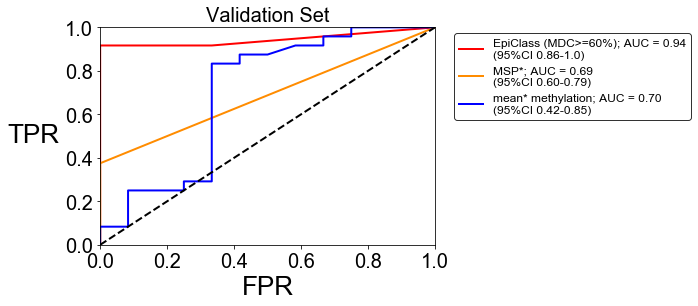

In [9]:
fig, ax = plt.subplots()
lw = 2

plt.plot(mdOpt_fpr, mdOpt_tpr, color='red',
         lw=lw, label='EpiClass (MDC>=60%)' + '; AUC = %0.2f' % mdOpt_roc_auc + '\n(95' + '%' + 'CI 0.86-1.0)')

plt.plot(msp_fpr, msp_tpr, color='darkorange',
         lw=lw, label='MSP*' + '; AUC = %0.2f' % msp_roc_auc + '\n(95' + '%' + 'CI 0.60-0.79)')

plt.plot(md0_fpr, md0_tpr, color='blue',
         lw=lw, label='mean* methylation' + '; AUC = %0.2f' % md0_roc_auc + '\n(95' + '%' + 'CI 0.42-0.85)')

plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')

plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.00])

plt.title('Validation Set', fontsize=20)
plt.xlabel('FPR', fontsize=26)
plt.ylabel('TPR', rotation=0, fontsize=26)
ax.yaxis.set_label_coords(-0.20, 0.45)

plt.xticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                   for i in np.arange(0, 1.1, .2)], fontsize=20)
plt.yticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                   for i in np.arange(0, 1.1, .2)], fontsize=20)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left",
           fontsize=12, edgecolor='k')
#plt.show()
plt.savefig('FigureS8C_validationSet_MDcutoffs_ROC.png',
            bbox_inches='tight', pad_inches=0.5, dpi=500)


### Use cutoffs from training and determine TPR/FPR and ability to classify serous vs nonserous compared to CA125

#### for validation set subtype and CA125 values:
#### ./dreaming_samples.csv

#### CA125/U/mL cutoff defined as 35U/mL

In [10]:
# test cutoffs on validation set:

samplesTable = "dreaming_samples.csv"  # has subtype and CA-125 information
sample_df = pd.read_csv(samplesTable)
valOVs = sample_df[['validation_ovs',
                    'validation_ovs_subtype', 'validation_ovs_ca125']].dropna()

md0_df = pd.read_csv(md0_val_path)
mdOpt_df = pd.read_csv(mdOpt_val_path)
msp_df = pd.read_csv(msp_val_path)

valOVs[valOVs['validation_ovs_ca125'] >= 35.0]

ID_cases_opt = mdOpt_df[mdOpt_df['cases'] >= mdOpt_cutoff]['case_samples']
valOVs[valOVs['validation_ovs'].isin(ID_cases_opt)]
ID_controls_opt = mdOpt_df[mdOpt_df['controls'] >= mdOpt_cutoff]['control_samples']

ID_cases_msp = msp_df[msp_df['cases'] >= msp_cutoff]['case_samples']
valOVs[valOVs['validation_ovs'].isin(ID_cases_msp)]
ID_controls_msp = msp_df[msp_df['controls'] >= msp_cutoff]['control_samples']

ID_cases_md0 = md0_df[md0_df['cases'] >= md0_cutoff]['case_samples']
valOVs[valOVs['validation_ovs'].isin(ID_cases_md0)]
ID_controls_md0 = md0_df[md0_df['controls'] >= md0_cutoff]['control_samples']

In [11]:
valOVs[valOVs['validation_ovs'].isin(ID_cases_opt)]

,validation_ovs,validation_ovs_subtype,validation_ovs_ca125
0,ASCS-P001,serous,297.0
1,DJNG-P001,serous,22.0
5,FOXX-P001,nonserous,27.0
6,FELD-P001,nonserous,5.6
8,ASCS-P002,serous,358.0
9,DJNG-P002,serous,15.0
10,VCTD-P002,serous,153.0
11,MUZP-P002,serous,315.0
12,ESCP-P002,nonserous,3.6
13,FOXX-P002,nonserous,34.0


In [12]:
ID_controls_opt

Series([], Name: control_samples, dtype: float64)

In [13]:
valOVs[valOVs['validation_ovs'].isin(ID_cases_msp)]

,validation_ovs,validation_ovs_subtype,validation_ovs_ca125
1,DJNG-P001,serous,22.0
8,ASCS-P002,serous,358.0
9,DJNG-P002,serous,15.0
11,MUZP-P002,serous,315.0
13,FOXX-P002,nonserous,34.0
16,ASCS-P003,serous,182.0


In [14]:
ID_controls_msp

Series([], Name: control_samples, dtype: float64)

In [15]:
valOVs[valOVs['validation_ovs'].isin(ID_cases_md0)]

,validation_ovs,validation_ovs_subtype,validation_ovs_ca125
0,ASCS-P001,serous,297.0
1,DJNG-P001,serous,22.0
3,MUZP-P001,serous,326.0
4,ESCP-P001,nonserous,2.5
5,FOXX-P001,nonserous,27.0
6,FELD-P001,nonserous,5.6
8,ASCS-P002,serous,358.0
9,DJNG-P002,serous,15.0
10,VCTD-P002,serous,153.0
11,MUZP-P002,serous,315.0


In [16]:
ID_controls_md0

1     102598.0
4     100250.0
6     103197.0
8     100292.0
9     102126.0
10    100662.0
Name: control_samples, dtype: float64

In [17]:
valOVs[ (valOVs['validation_ovs'].isin(ID_cases_opt)) | (valOVs['validation_ovs_ca125'] > 35.0) ]

,validation_ovs,validation_ovs_subtype,validation_ovs_ca125
0,ASCS-P001,serous,297.0
1,DJNG-P001,serous,22.0
3,MUZP-P001,serous,326.0
5,FOXX-P001,nonserous,27.0
6,FELD-P001,nonserous,5.6
7,DUFF-P001,serous,137.0
8,ASCS-P002,serous,358.0
9,DJNG-P002,serous,15.0
10,VCTD-P002,serous,153.0
11,MUZP-P002,serous,315.0


In [18]:
valOVs

,validation_ovs,validation_ovs_subtype,validation_ovs_ca125
0,ASCS-P001,serous,297.0
1,DJNG-P001,serous,22.0
3,MUZP-P001,serous,326.0
4,ESCP-P001,nonserous,2.5
5,FOXX-P001,nonserous,27.0
6,FELD-P001,nonserous,5.6
7,DUFF-P001,serous,137.0
8,ASCS-P002,serous,358.0
9,DJNG-P002,serous,15.0
10,VCTD-P002,serous,153.0
